In [4]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt

In [5]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

In [166]:
def gaussian(f, f_0, a, sigma, c, b):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def linear(x, a, b):
    return a*x + b

def get_gaussian_fit(detunings, voltages):    
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_p0({"a": -1})
    fitter.set_data(detunings, voltages)
    fitter.fit()
    
    return fitter

def get_linear_fit(amplitudes, heights):
    fitter = Fitter(linear)
    fitter.set_absolute_sigma(False)
    fitter.set_data(amplitudes, heights)
    fitter.fit()

    return fitter

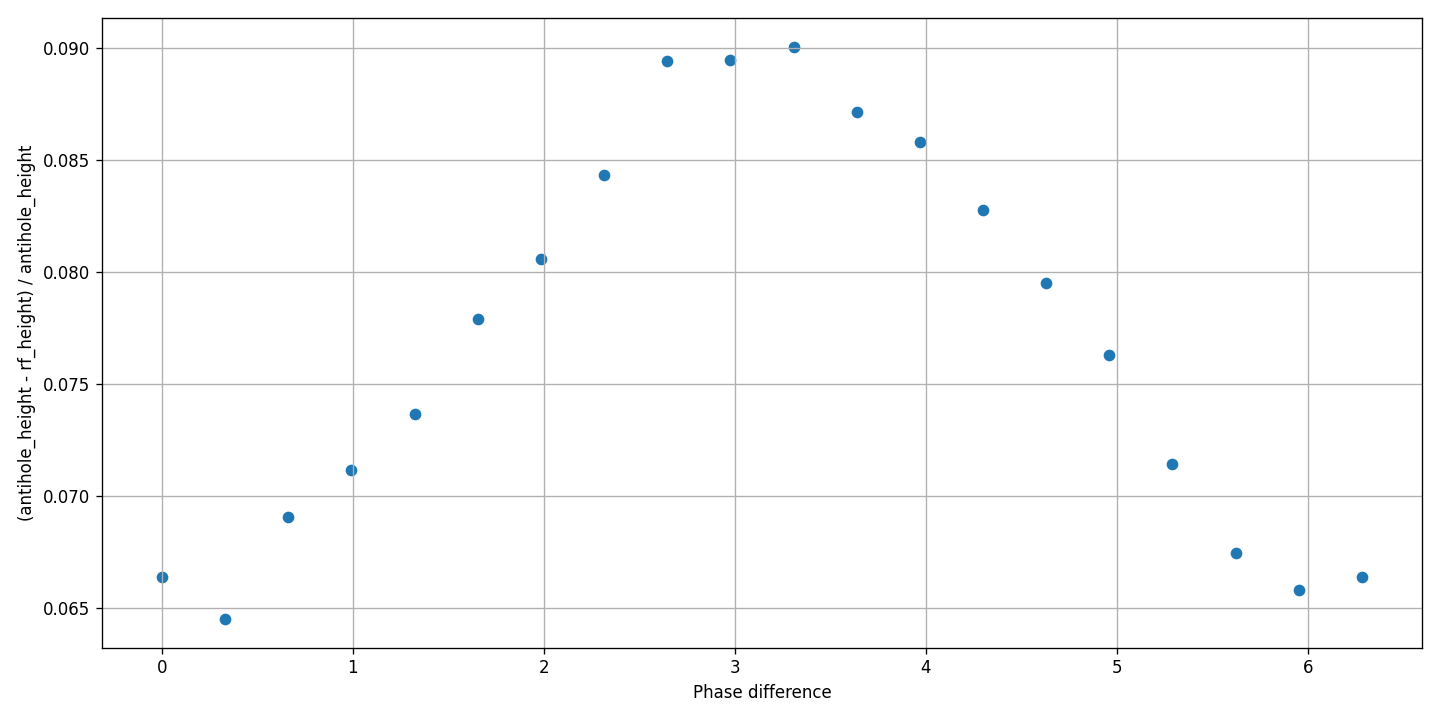

20


In [205]:
use_chasm = True

antihole_heights = []
antihole_height_errs = []
rf_heights = []
rf_height_errs = []
delay_times = []
rf_phases = []
# for kk in range(3990, 4090):  # 1 to 2 ms scan
for kk in range(4235, 4255):
    data, headers = get_experiment_data(kk)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    delay_time = headers["params"]["rf"]["delay_time"].to("ms").magnitude
    rf_phases.append(headers["params"]["rf"]["phase"])
    delay_times.append(delay_time)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    if use_chasm:
        antihole_fit = get_gaussian_fit(detunings_MHz, antihole_avg/chasm_avg)
        rf_fit = get_gaussian_fit(detunings_MHz, rf_avg/chasm_avg)
    else:
        antihole_fit = get_gaussian_fit(detunings_MHz, antihole_avg/monitor_antihole_avg)
        rf_fit = get_gaussian_fit(detunings_MHz, rf_avg/monitor_rf_avg)
    antihole_heights.append(antihole_fit.results["a"])
    antihole_height_errs.append(antihole_fit.errors["a"])
    rf_heights.append(rf_fit.results["a"])
    rf_height_errs.append(rf_fit.errors["a"])

antihole_heights = np.array(antihole_heights)
antihole_height_errs = np.array(antihole_height_errs)
rf_heights = np.array(rf_heights)
rf_height_errs = np.array(rf_height_errs)
delay_times = np.array(delay_times)
rf_phases = np.array(rf_phases)

fig, ax = plt.subplots(figsize=(12, 6), dpi = 120)
ratios = rf_heights / antihole_heights
ratio_errs = ratios * np.sqrt(
    (rf_height_errs / rf_heights) ** 2
    + (antihole_height_errs / antihole_heights) ** 2
)
colors = np.linspace(0, 1, len(ratios))

ax.scatter(rf_phases, 1 - ratios)
# ca = ax.scatter(delay_times, 1 - ratios, c = colors, cmap = "jet", zorder = 2)
# ax.legend()
# cbar = plt.colorbar(ca)
# cbar.ax.text(5, 1, "Latest data", ha='center', va='center')
# cbar.ax.text(5, 0, "Oldest data", ha='center', va='center')
# ax.set_xlabel("CQB delay time (ms)")
ax.set_xlabel("Phase difference")
ax.set_ylabel("(antihole_height - rf_height) / antihole_height")
plt.grid()
plt.tight_layout()
plt.show()
print(len(ratios))

In [915]:
print(fitter.all_results_str())
print(fitter.results["Omega"]/2/np.pi)

a = 0.43(6)
Omega = 11200(300)
tau = 0.0019(13)
c = 0.008(2)
Reduce chi-square is undefined.
1783.6735297217008


/tmp/ipykernel_29082/4204129173.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return a * quad(integrand, -span, span)[0] + c


In [181]:
data, headers = get_experiment_data(4158)
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

5.291103416572283


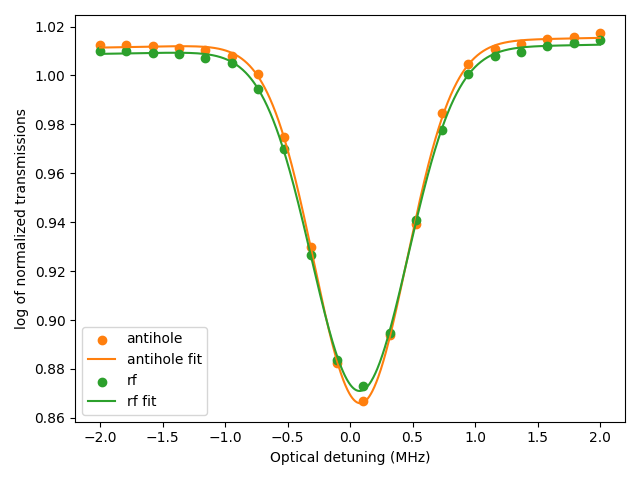

f_0 = 0.082(3)
a = -0.1475(10)
sigma = 0.372(3)
c = 1.0135(4)
b = 0.0010(3)
Reduce chi-square is undefined.
f_0 = 0.077(3)
a = -0.1398(9)
sigma = 0.388(3)
c = 1.0108(4)
b = 0.0009(2)
Reduce chi-square is undefined.


In [182]:
print(headers["params"]["rf"]["phase_1"])
antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg
rf_normalized_by_antihole = rf_normalized / antihole_normalized

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")

xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    #ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    #ax.scatter(detunings_MHz, rf_normalized_by_antihole, label="rf", color="C1")
    #ax.scatter(detunings_MHz, np.average(rf_avg, axis=0) / np.average(antihole_avg, axis=0), label="rf / antihole")

    # rf_fit = get_double_gaussian_fit(detunings_MHz, rf_normalized_by_antihole)]
    rf_fit = get_gaussian_fit(detunings_MHz, rf_normalized)
    #rf_fit = get_quadratic_fit(detunings_MHz, log_rf_normalized)
    ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("log of normalized transmissions")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print(rf_fit.all_results_str())

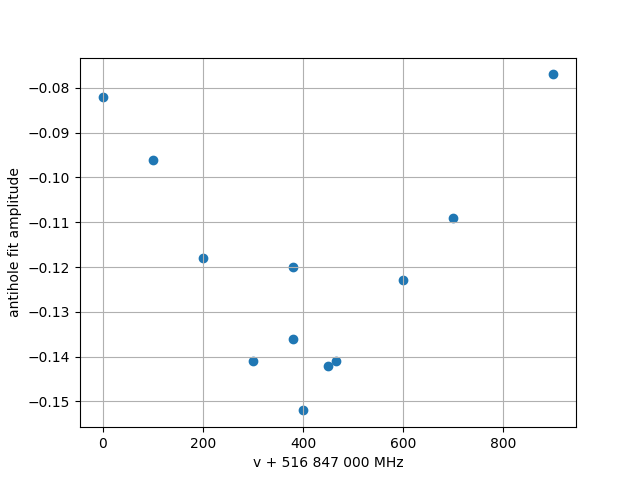

In [178]:
# fig, ax = plt.subplots()
# # ax.scatter(detunings_MHz, rf_avg, label="chasm", color="C0")
# # ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
# ax.scatter(detunings_MHz, rf_avg/chasm_avg)
# plt.show()


# a     sigma freq num
#-0.120 0.331 380 3778
#-0.154 0.349 450 3779 - while scanning
#-0.144 0.356 500 3780 - while scanning
#-0.138 0.376 465 3781 - while scanning
#-0.141 0.354 465 3782
#-0.142 0.385 450 3783
#-0.123 0.334 600 3784
#-0.109 0.332 700 3785
#-0.077 0.367 900 3786
#-0.141 0.396 300 3787
#-0.118 0.388 200 3788


freqs = [380, 465, 450, 600, 700, 900, 300, 200, 100, 0, 400, 380]
aas = [-0.120, -0.141, -0.142, -0.123, -0.109, -0.077, -0.141, -0.118, -0.096, -0.082, -0.152, -0.136]


fig, ax = plt.subplots()
ax.scatter(freqs, aas)
ax.set_ylabel("antihole fit amplitude")
ax.set_xlabel("v + 516 847 000 MHz")
plt.grid()
plt.show()

In [769]:
def excited_state_population(Omega, t, delta):
    W = np.sqrt(Omega**2 + delta**2)
    return Omega**2 / W**2 * np.sin(W * t / 2) ** 2

In [805]:
def excited_state_population_inhom(Omega, t, delta_max, steps):
    total = np.zeros(len(t))
    for delta in np.linspace(-delta_max, delta_max, steps):
        total += excited_state_population(Omega, t, delta)
    return total / steps

TypeError: object of type 'float' has no len()

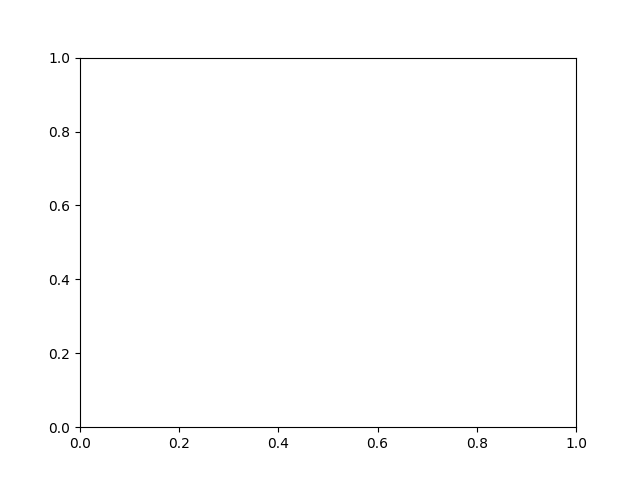

In [812]:
fig, ax = plt.subplots()
t = 0.2e-3
Omegas = np.linspace(0, 0.5e5, 300)
ax.plot(Omegas, excited_state_population_inhom(Omegas, 2*t, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 2, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 4, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 8, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 16, 100000, 100000))
plt.show()

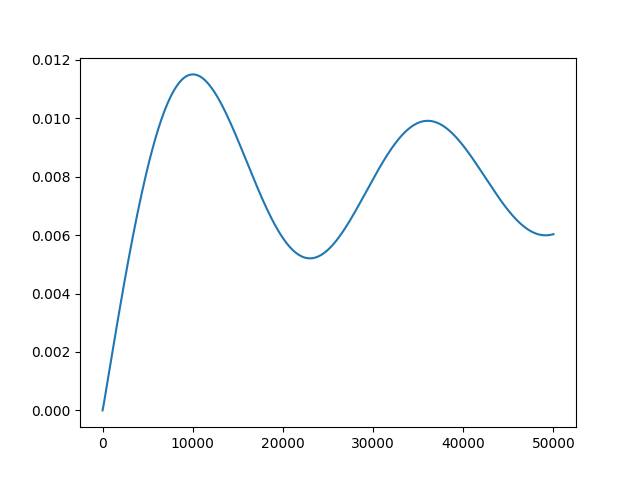

In [810]:
fig, ax = plt.subplots()
Omega = 1e3
ts = np.linspace(0, 12e-3, 300)
ax.plot(Omegas, excited_state_population_inhom(Omega, ts, 100000, 100000))
plt.show()